In [126]:
#using ReadWriteDlm2 
#using Pkg
#Pkg.add("Dierckx")

In [1]:
using DifferentialEquations
using Plots; pyplot()
using DelimitedFiles  #https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/  
using Interpolations

using Dierckx

#ToDo

    * include fundamnetal constants as module

    module myconstants 
    include("myconstants.jl")
    end

    using myconstants
    print(myconstants.CGS_C)
    
    * numerical derivative of array to calculate gamma 
    * root finding 
    * time everything 

-13.14817757622002:0.1:0.9518224237799817

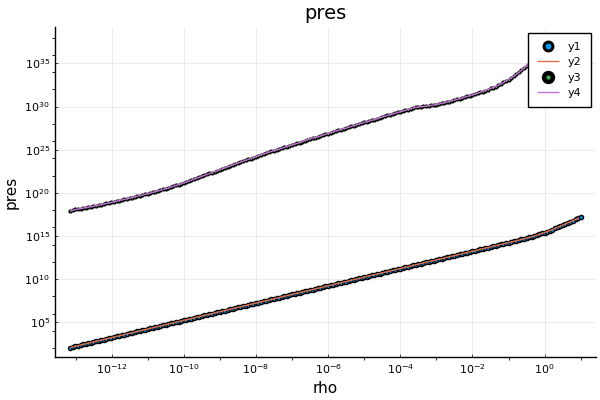

In [2]:
eos_tablefile = "./eos_tables/eosDD2.lorene"
eos_table = readdlm(eos_tablefile,Float64, skipstart=10, comments=true, comment_char='#') #, delim::AbstractChar, Float64 , eol::AbstractChar; header=false, skipblanks=true, use_mmap, quotes=true, dims)


index = eos_table[:,1,1,1]
rho   = eos_table[:,2,1,1] 
edens = eos_table[:,3,1,1]
pres  = eos_table[:,4,1,1]


rho_scaling = 3.2202e+15
edens_scale = 
lgrho = log10.(rho)
lgedens = log10.(edens)
lgpres = log10.(pres)

#lgrhomin = Float64()
#lgrhomax = Float64()
rho_new = minimum(lgrho):0.1:maximum(lgrho)
print(rho_new)
rho2pres  = LinearInterpolation(lgrho, lgpres) 
#rho2pres  = CubicSplineInterpolation(lgrho, lgpres; bc=Line(OnGrid()))
rho2edens = LinearInterpolation(lgrho, lgedens)

pres2edens = LinearInterpolation(lgpres,lgedens)
pres2rho   = LinearInterpolation(lgpres,lgrho)

lgpres_new = [rho2pres(x) for x in rho_new]
lgedens_new = [rho2edens(x) for x in rho_new]


scatter(rho,edens,markersize=3)
plot!(10 .^ rho_new, 10 .^ lgedens_new,markersize=1, xaxis=:log, yaxis=:log,xlabel="rho",ylabel="edens",lw=1,title="INTERPOLATION SUCCESSFUL!") #,color=[:red,:green])

gr()
scatter!(rho,pres,markersize=2)
plot!(10 .^ rho_new, 10 .^ lgpres_new, xaxis=:log, yaxis=:log,xlabel="rho",ylabel="pres",lw=1,title="pres")

#plot(pln_edens, pln_pres, layout = (1, 2), legend = false)
#pl_edens = plot!(10 .^ rho_new, 10 .^ lgedens_new)
#pl_pres  = plot!(10 .^ rho_new, 10 .^ lgpres_new)
#plot!(pln_edens, pln_pres, layout = (1, 2), legend = false)

In [3]:
function Λ(C, Y)
    # """ Compute the dimensionless tidal deformability parameter Lambda from the compactness C and 
    # the Lindblom y-potential at the surface of a polytropic star"""
    # Eq.(C1,C2) of Lindblom & Indik 2014
    zeta = 4 * C^3 * (13 - 11 * Y + C*(3*Y-2) + 2*(C^2)*(1+Y)) + 3 * ((1-2*C)^2) * (2 - Y + 2*C*(Y-1)) * log(1-2*C) + 2 * C * (6 - 3*Y + 3*C*(5*Y-8))
    Lambda_dimensionless = (16/(15*zeta)) * ((1-2*C)^2) * (2 + 2*C*(Y-1) - Y)  #dimensionless tidal deformability
    #lambda_dimensional =   Lambda_dimensionless/const.CGS_G *(const.CGS_G*m*const.CGS_MSUN/const.CGS_C**2)**5
end

#=
function tab = LoadEOSTab(fname)
% Load EOS table
% Format (ASCII, 4 cols):
%
% #
% #
% #
% nlines
% #
% #
% #
% index n[1/cm^3] e[g/cm^3] p[dyn/cm^2]  -- convert them to G=c=M_⊙=1 unit
%
    
fid = fopen(fname,'r');
col = textscan(fid,'%n%n%n%n','Headerlines',7);
fclose(fid);
%Length_fm = 1.476701332464468e+18; % cm
             %rahul: New Value          %rahul: old value
units.vol  = 3.219379180793e15;         %3.2202e+15;  this is  (GM/c^2)^3
units.pres = 5.548820759138184e+38;
units.mden = 6.176656704073912e17;      %6.173895728686583e+17;  units.vol/units.Msun 
units.mB   = 1.66e-24                   %1.675e-24;
units.Msun = 1.9885e33                  %1.9889e+33; 
tab.rho = col{2} * units.mB / units.mden;
%tab.lgn = log10( col{2} * units.vol );
tab.lgr = log10( tab.rho );
%tab.lgr = log10( col{2} * units.mB * units.vol / units.mden ); % rho = mB n % !
tab.lge = log10( col{3} / units.mden );
tab.lgp = log10( col{4} / units.pres );
=#
    
@time print(Λ(0.3,1000.))

-14.818554577452705  0.075998 seconds (392.24 k allocations: 21.432 MiB, 99.86% compilation time)


In [131]:
## in the unit, G=c=M⊙=1 
# interpolating EoS table -- https://discourse.julialang.org/t/using-interpolations/23933/32 
function tov!(du,u,p,r)
 #G=1   
    
 mg   = u[1]
 pres = u[2]
 #u[3] is not used in the differential system anywhere. 
 yp   = u[4]
 
 eden = 10^pres2edens(log10(pres))
 rho  = 10^pres2rho(log10(pres))
 eos_gamma = 2.1
    
 du[1] = 4.0*pi* r^2 *eden      #dm_grav/dr
 du[2] = -(eden + pres)*(mg + 4.0*pi*r^3*pres) / (r*(r - 2.0*mg))  #dpres/dr
 du[3] = du[1]*(1-2*mg/r)^(-0.5)  #dm_baryon/dr 
 du[4] = -yp^2/r -(r + 4*pi*r^3*(pres-rho))*yp/(r*(r-2*u[1])) + (4*(u[1]+4*pi*r^3*pres)^2)/(r*(r-2*u[1])^2) + 6/(r-2*u[1]) - 4*pi*(r^2)*(5*rho+9*pres+(rho+pres)^2/(pres*eos_gamma))/((r-2*u[1]))
end

rhoc = 8
Δr = 1.e-7
mg0 = 4/3 * π * Δr^3 * rhoc
p0 = 10^rho2pres(log10(rhoc))  ## get pressure at rhoc using EOS
mb0 = mg0/(Δr-2mg0)
y0 = 2

u0 = [mg0;p0;mb0;y0]
rspan = (1.e-7,20.0)
@time prob = ODEProblem(tov!,u0,rspan)
sol = solve(prob)

plot(sol,vars=(2,3))

  0.000308 seconds (443 allocations: 35.047 KiB)


LoadError: DomainError with -1.3775276000632743e63:
NaN result for non-NaN input.

In [123]:
tov_filename = "./matlab_Sebastiano/tov/Sequences/Stable/DD2_sequence.txt"
tovseq = readdlm(tov_filename,Float64, skipstart=0, comments=true, comment_char='#') #, delim::AbstractChar, T::Type, eol::AbstractChar; header=false, skipstart=0, skipblanks=true, use_mmap, quotes=true, dims, comments=false, comment_char='#')
#"APR4_data.out"
#print(tovseq)





106×7 Matrix{Float64}:
 0.000294509  0.125561  0.126492  18.3014   …  0.00179211       7.8601e7
 0.000312385  0.137081  0.138219  15.9171      0.00342011       4.8125e7
 0.00033026   0.149635  0.151023  14.3101      0.00572645       3.05379e7
 0.000348136  0.16332   0.165005  13.0964      0.00893269       1.97452e7
 0.000366012  0.178243  0.180287  12.2014      0.012887         1.29136e7
 0.000383888  0.194524  0.196998  11.4935   …  0.0177271        8.51028e6
 0.000401763  0.212281  0.215268  10.934       0.0233399        5.64085e6
 0.000419639  0.231618  0.235216  10.4847      0.0296556        3.75774e6
 0.000437515  0.252636  0.256964  10.1311      0.0363785        2.51511e6
 0.000455391  0.275435  0.280626   9.83146     0.0437827        1.69124e6
 0.000473267  0.300083  0.306292   9.59577  …  0.0512805        1.14303e6
 0.000491142  0.326619  0.334025   9.41035     0.0587053        7.76977e5
 0.000509018  0.355069  0.363872   9.25271     0.0663489   531525.0
 ⋮                     

## Practice with several julia commands

0.9843850638769859
1.1273804959132878
-0.06931471805599451
[0.0, 0.13862943611198902, 0.27725887222397805, 0.41588830833596724, 0.5545177444479562, 0.6931471805599453, 0.7742402021815782, 0.855333223803211, 0.936426245424844, 1.0175192670464768, 1.0986122886681098, 1.156148703158466, 1.2136851176488221, 1.2712215321391782, 1.3287579466295343, 1.3862943611198906, 1.4309230713827326, 1.4755517816455745, 1.5201804919084163, 1.5648092021712583, 1.6094379124341003, 1.6459022237928913, 1.682366535151682, 1.7188308465104731, 1.755295157869264, 1.791759469228055, 1.8225896051935067, 1.8534197411589584, 1.88424987712441, 1.9150800130898615, 1.9459101490553132, 1.9726164275802176, 1.9993227061051222, 2.0260289846300266, 2.0527352631549314, 2.0794415416798357, 2.1029981488111122, 2.126554755942389, 2.150111363073666, 2.173667970204943, 2.1972245773362196, 2.218296680467785, 2.23936878359935, 2.2604408867309154, 2.2815129898624806, 2.302585092994046]

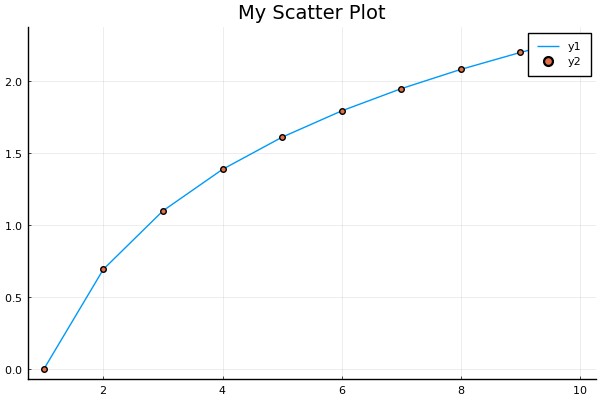

In [14]:
using Interpolations
using Plots; pyplot()
#default(show = true)

xs = 1:1:10
f(x) = log(x)
A = [f(x) for x in xs]

interp_linear = LinearInterpolation(xs, A) 
#etp = CubicSplineInterpolation(xs, A; bc=Line(OnGrid()), extrapolation_bc=Throw()) 

#print(etp(271.8281),'\n') 
print(interp_linear(2.718281),'\n') # exactly log(3)
print(interp_linear(3.1),'\n') # approximately log(3.1)
#interp_linear(0.9) # outside grid: error


interp_linear_extrap = LinearInterpolation(xs, A,extrapolation_bc=Line()) 
print(interp_linear_extrap(0.9)) # outside grid: linear extrapolation

xnew = 1:0.2:10
Anew = [interp_linear(x) for x in xnew]
print('\n',Anew)
plot(xnew,Anew)

plot!(xs,A,seriestype = :scatter, title = "My Scatter Plot")

  0.000274 seconds (443 allocations: 35.047 KiB)


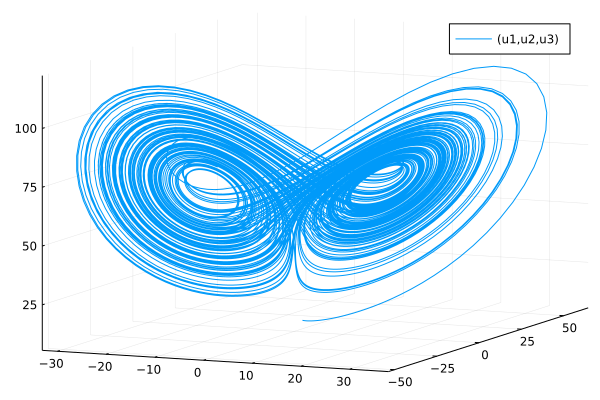

In [2]:
using DifferentialEquations
using Plots

function lorenz!(du,u,p,t)
 du[1] = 10.0*(u[2]-u[1])
 du[2] = u[1]*(68.0-u[3]) - u[2]
 du[3] = u[1]*u[2] - (8/3)*u[3]
end

u0 = [1.0;2.0;10.0]
tspan = (0.0,100.0)
@time prob = ODEProblem(lorenz!,u0,tspan)
sol = solve(prob)

#plot(sol,vars=(2,3))
plot(sol,vars=(1,2,3))